In [10]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()
import ipywidgets

from scipy import signal
from intervals import FloatInterval
from scipy.signal import butter, lfilter
from scipy.signal import freqz

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss 
from sklearn.model_selection import cross_val_score

import xgboost as xgb

In [2]:
dataPath = "C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"

trainOutput = pd.read_csv(dataPath + "challenge_fichier_de_sortie_dentrainement_classification_en_stade_de_sommeil_a_laide_de_signaux_mesures_par_le_bandeau_dreem.csv", sep=";")
Y = trainOutput["label"]

In [3]:
filetrain= dataPath + "train.h5"
filetest= dataPath + "test.h5"

In [4]:
h5 = h5py.File(filetrain, "r")
eeg_1 = pd.DataFrame(h5['eeg_1'][:])
eeg_2 = pd.DataFrame(h5['eeg_2'][:])
eeg_3 = pd.DataFrame(h5['eeg_3'][:])
eeg_4 = pd.DataFrame(h5['eeg_4'][:])
po_ir = pd.DataFrame(h5['po_ir'][:])
po_r = pd.DataFrame(h5['po_r'][:])
accelerometer_x = pd.DataFrame(h5['accelerometer_x'][:])
accelerometer_y = pd.DataFrame(h5['accelerometer_y'][:])
accelerometer_z = pd.DataFrame(h5['accelerometer_z'][:])



In [8]:
def spectrogram_by_eeg_bandwidth(sig, sample_rate=125, timeIntervalSec=2):
    delta = FloatInterval.from_string('[0, 4.0)')
    theta = FloatInterval.from_string('[4.0, 8.0)')
    alpha = FloatInterval.from_string('[8.0, 16.0)')
    beta = FloatInterval.from_string('[16.0, 32.0)')
    gamma = FloatInterval.from_string('[32.0, 100.0)')
    above100Hz = FloatInterval.from_string('[100.0,)')
    #
    nperseg = int(sample_rate * timeIntervalSec)
    noverlap = 0
    freqs, times, spec = signal.spectrogram(sig,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=sample_rate*timeIntervalSec,
                                    noverlap=noverlap,
                                    detrend=False)
    #Edelta, Etheta, Ealpha, Ebeta, Egamma, Eabove100Hz = np.zeros(6)
    result = pd.DataFrame(np.zeros(spec.shape[1]*6).reshape((6, spec.shape[1])), index=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Above100Hz'])
    #
    for i in range(0, spec.shape[0]):
        for j in range(0, spec.shape[1]):
            if freqs[i] in delta:
                result.loc["Delta", j]= result.loc["Delta", j] + spec[i, j]
            elif freqs[i] in theta:
                result.loc["Theta", j]= result.loc["Theta", j] + spec[i, j]
            elif freqs[i] in alpha:
                result.loc["Alpha", j]= result.loc["Alpha", j] + spec[i, j]
            elif freqs[i] in beta:
                result.loc["Beta", j]= result.loc["Beta", j] + spec[i, j]
            elif freqs[i] in gamma:
                result.loc["Gamma", j]= result.loc["Gamma", j] + spec[i, j]
            elif freqs[i] in above100Hz:
                print(str((i, j)) + "added tp above100Hz")
                result.loc["Above100Hz", j]= result.loc["Above100Hz", j] + spec[i, j]
            else:
                print("error at cell " + str((i, j)))
    return result

In [9]:
def generate_columns_names(L=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Above100Hz'], n=15):
    r = "["
    for i in L:
        for j in range(0,n):
            if (i == L[-1]) and (j==n-1):
                r = r + "'" + str(i)+ str(j) + "']"
            else:
                r = r + "'" + str(i)+ str(j) + "',"
    return eval(r)


def make_eeg_spectogram_dataframe(eeg, timeIntervalSec, columnsName=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Above100Hz']):
    columns = generate_columns_names(n = 30//timeIntervalSec, L=columnsName)
    df = pd.DataFrame(columns = columns)
    for i in range(0, eeg.shape[0]):
        spec = spectrogram_by_eeg_bandwidth(eeg.iloc[i,:], 
            sample_rate=125, timeIntervalSec=timeIntervalSec)
        t = spec.values.reshape(1, spec.shape[0]*spec.shape[1])
        #df.loc[i] = [j for j in t[0]]
        df.loc[i] = t[0]
    return df   
    


In [10]:

def build_spectrogram_eeg_features(h5filename, timeIntervalSec, dataPath="C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\raw\\"):
    h5file= dataPath + h5filename
    h5 = h5py.File(h5file, "r")
    eeg_1 = pd.DataFrame(h5['eeg_1'][:])
    eeg_2 = pd.DataFrame(h5['eeg_2'][:])
    eeg_3 = pd.DataFrame(h5['eeg_3'][:])
    eeg_4 = pd.DataFrame(h5['eeg_4'][:])
    
    print("start FTT on eeg_1")
    eeg1 = make_eeg_spectogram_dataframe(eeg_1, timeIntervalSec, 
                                         columnsName=['eeg1_Delta', 'eeg1_Theta', 'eeg1_Alpha', 'eeg1_Beta', 'eeg1_Gamma', 'eeg1_Above100Hz'])
    print("start FTT on eeg_2")
    eeg2 = make_eeg_spectogram_dataframe(eeg_2, timeIntervalSec, 
                                         columnsName=['eeg2_Delta', 'eeg2_Theta', 'eeg2_Alpha', 'eeg2_Beta', 'eeg2_Gamma', 'eeg2_Above100Hz'])
    print("start FTT on eeg_3")
    eeg3 = make_eeg_spectogram_dataframe(eeg_3, timeIntervalSec, 
                                         columnsName=['eeg3_Delta', 'eeg3_Theta', 'eeg3_Alpha', 'eeg3_Beta', 'eeg3_Gamma', 'eeg3_Above100Hz'])
    print("start FTT on eeg_4")
    eeg4 = make_eeg_spectogram_dataframe(eeg_4, timeIntervalSec, 
                                         columnsName=['eeg4_Delta', 'eeg4_Theta', 'eeg4_Alpha', 'eeg4_Beta', 'eeg4_Gamma', 'eeg4_Above100Hz'])
    
    
    data = pd.concat([eeg1, eeg2, eeg3, eeg4], axis=1, sort=False)
    return data

,Delta0,Theta0,Alpha0,Beta0,Gamma0,Above100Hz0
0,15067.384836,791.799053,526.234402,238.067846,8.873436,0.0
1,6194.997941,870.974146,724.313661,222.860622,12.592876,0.0
2,4574.792936,498.015318,548.223114,169.697156,11.446063,0.0
3,317175.991019,14574.874852,19000.159158,892.029313,18.739333,0.0
4,58746.615386,7275.947515,15771.361858,664.287392,16.583832,0.0


In [72]:
test.to_excel('C:\\Users\\i053131\\Desktop\\Epilepsie\\Dreem\\data\\interim\\test.xlsx')

In [23]:
print(Y[22])
print(Y[29])
print(Y[34])
print(Y[44])
print(Y[250])

0
1
2
3
4


Awake

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


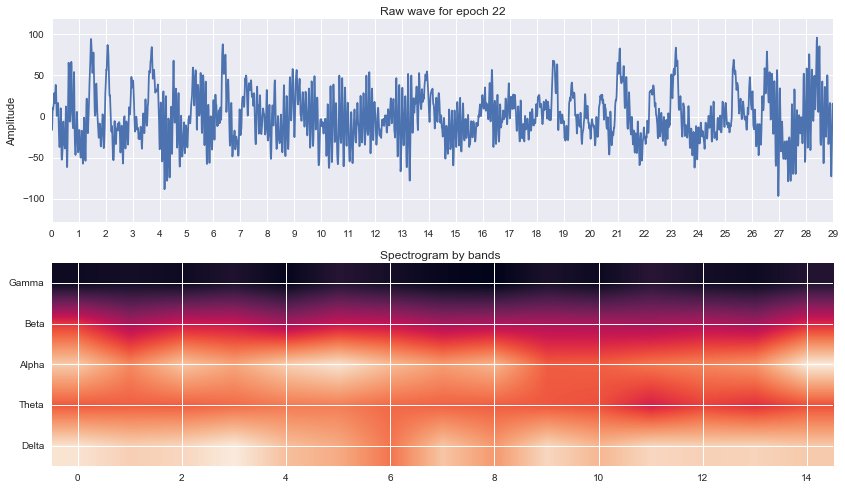

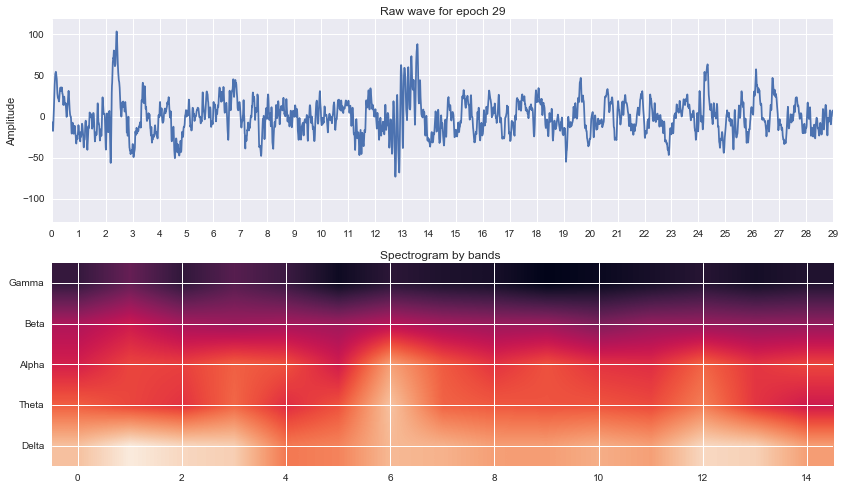

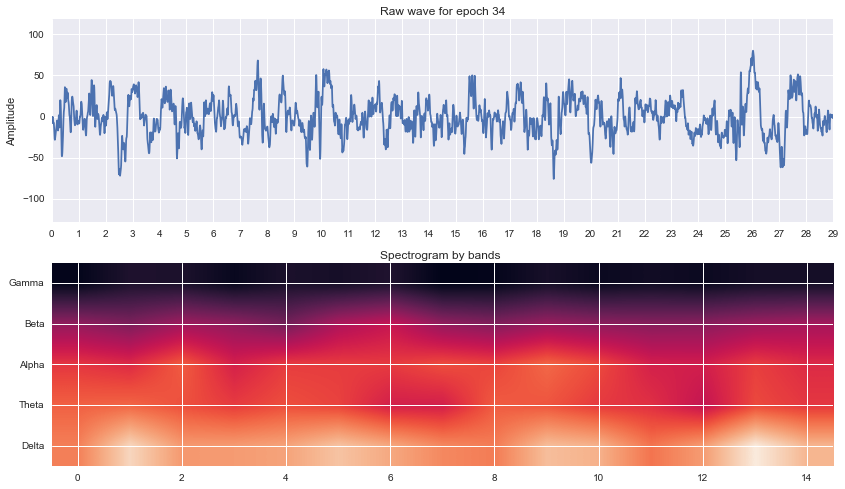

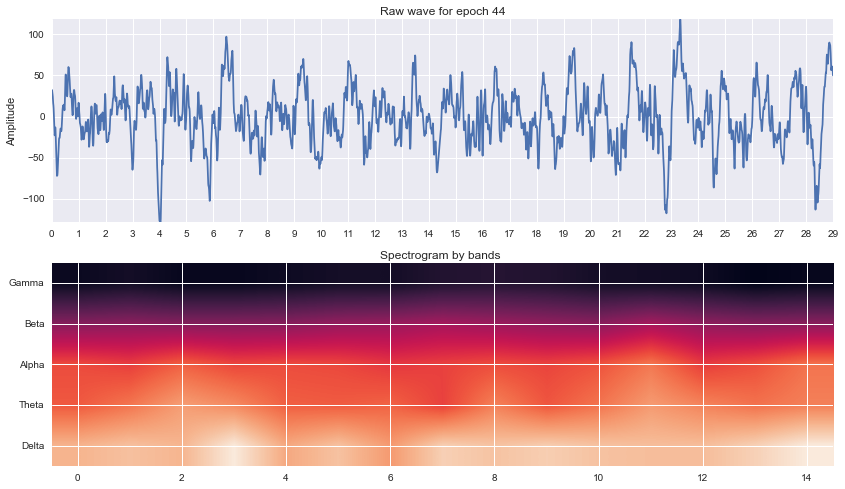

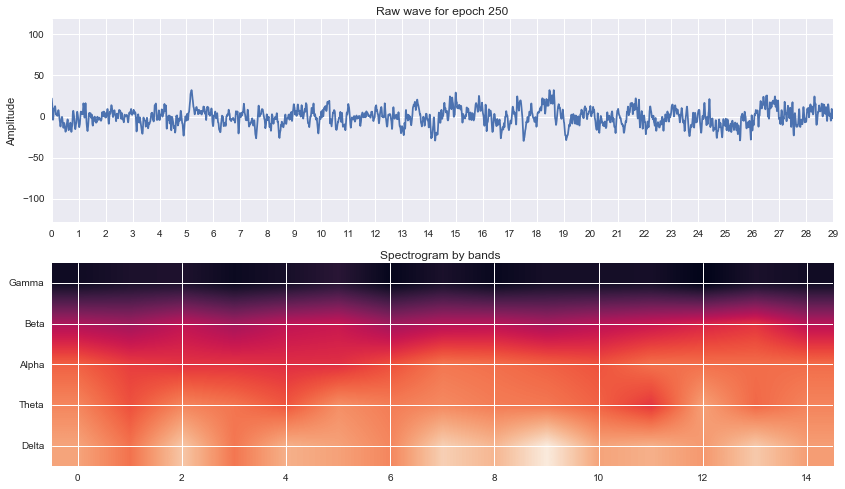

In [25]:
up, low = 0, 0
for i in [22, 29, 34, 44, 250]:
    up = max(eeg_1.iloc[i].max(), up)
    low = min(eeg_1.iloc[i].min(), low)

for i in [22, 29, 34, 44, 250]: #phases : 0, 1, 2, 3, 4

    sig = eeg_1.iloc[i]
    spec = np.log(spectrogram_by_eeg_bandwidth(sig).iloc[:-1, :])

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    ax1.set_ylim((low, up))
    ax1.plot(sig)
    #ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(212)
    im= ax2.imshow(spec, aspect='auto', origin='lower')
    #plt.matshow(spectrogram.T, aspect='auto', origin='lower')
    #ax2.set_yticks(freqs[::16])
    #ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram by bands ')

    ax2.yaxis.set_ticklabels(['0', 'Delta', 'Theta', 'Alpha', 'Beta', 'Gamma'])
    fig.show()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


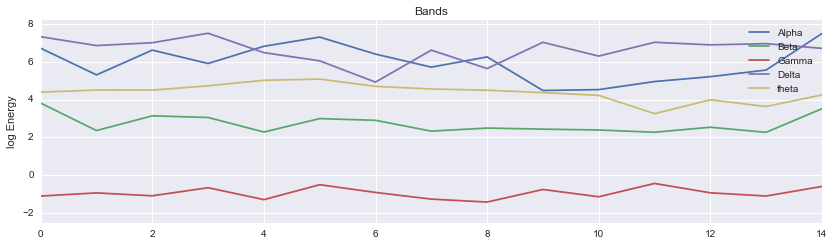

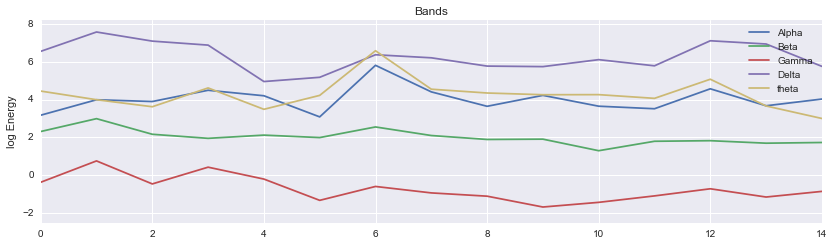

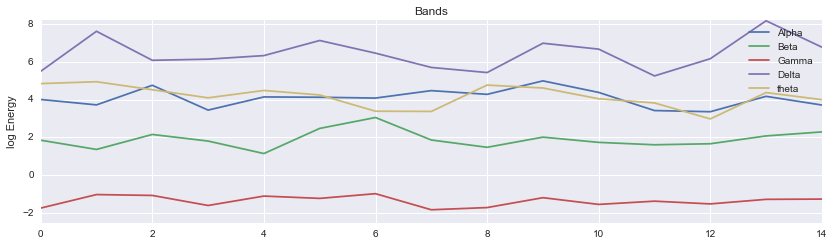

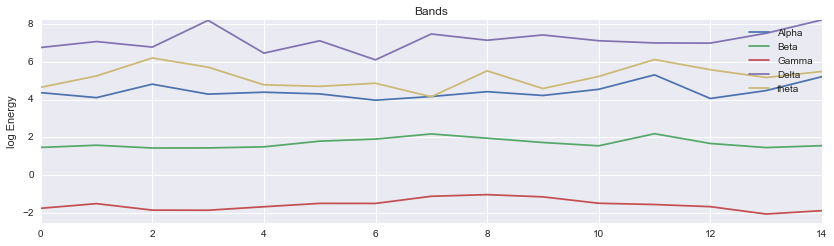

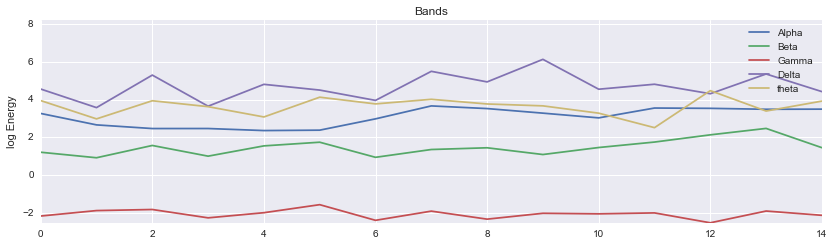

In [32]:
up, low = 0, 0
for i in [22, 29, 34, 44, 250]:
    sig = eeg_1.iloc[i]
    spec = np.log(spectrogram_by_eeg_bandwidth(sig).iloc[:-1, :])
    up = max(spec.T.max().max(), up)
    low = min(spec.T.min().min(), low)

for i in [22, 29, 34, 44, 250]: #phases : 0, 1, 2, 3, 4

    sig = eeg_1.iloc[i]
    spec = np.log(spectrogram_by_eeg_bandwidth(sig).iloc[:-1, :])

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Bands')
    ax1.set_ylabel('log Energy')
    #ax1.xaxis.set_ticks(np.linspace(0, len(samples), num=30))
    #ax1.xaxis.set_ticklabels(range(0,30))
    ax1.plot(spec.T["Alpha"], label = "Alpha")
    ax1.plot(spec.T["Beta"], label = "Beta")
    ax1.plot(spec.T["Gamma"], label = "Gamma")
    ax1.plot(spec.T["Delta"], label = "Delta")
    ax1.plot(spec.T["Theta"], label = "theta")
    ax1.set_ylim((low, up))
    ax1.legend()
    fig.show()

In [13]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [14]:
fs=125
lowcut = 4
highcut = 8
i=0
sig = eeg_1.iloc[i]

nyq = 0.5 *  fs
low = lowcut / nyq
high = highcut / nyq

[low, high]

butter(6, [low, high], btype='band')

(array([ 7.13752077e-07,  0.00000000e+00, -4.28251246e-06,  0.00000000e+00,
         1.07062812e-05,  0.00000000e+00, -1.42750415e-05,  0.00000000e+00,
         1.07062812e-05,  0.00000000e+00, -4.28251246e-06,  0.00000000e+00,
         7.13752077e-07]),
 array([ 1.00000000e+00, -1.07712202e+01,  5.36057579e+01, -1.62972396e+02,
         3.37067077e+02, -4.99599613e+02,  5.44131643e+02, -4.38770766e+02,
         2.59987486e+02, -1.10403055e+02,  3.18952812e+01, -5.62928596e+00,
         4.59090487e-01]))

In [16]:

y = butter_bandpass_filter(sig, lowcut, highcut, fs, order=6)
delta = FloatInterval.from_string('[0, 4.0)')
theta = FloatInterval.from_string('[4.0, 8.0)')
alpha = FloatInterval.from_string('[8.0, 16.0)')
beta = FloatInterval.from_string('[16.0, 32.0)')
gamma = FloatInterval.from_string('[32.0, 100.0)')
above100Hz = FloatInterval.from_string('[100.0,)')

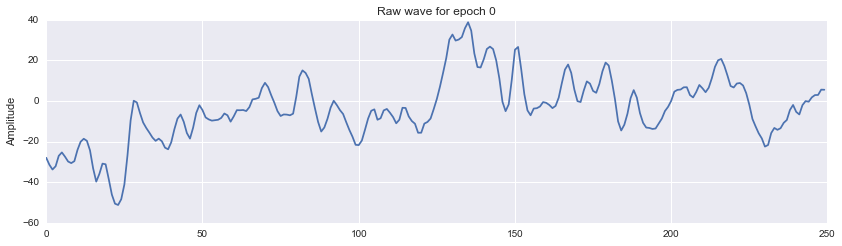

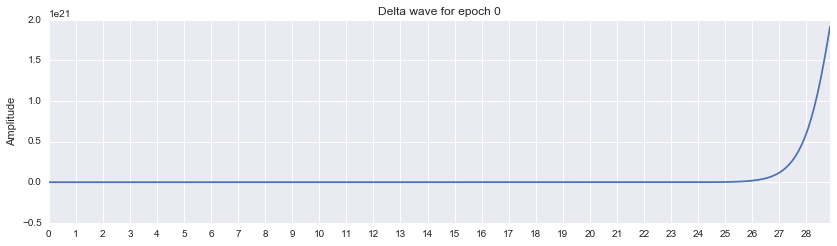

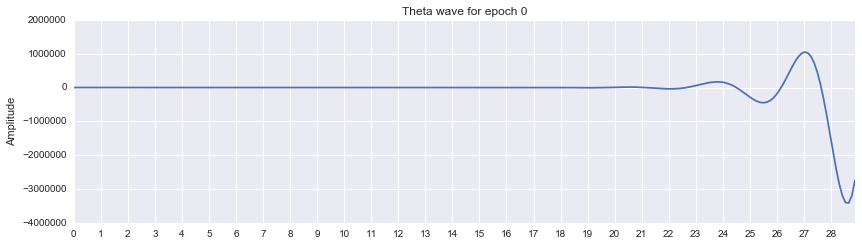

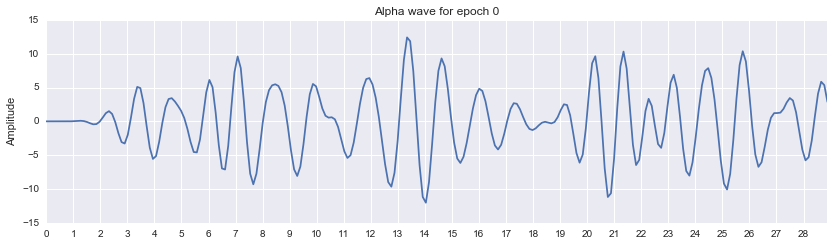

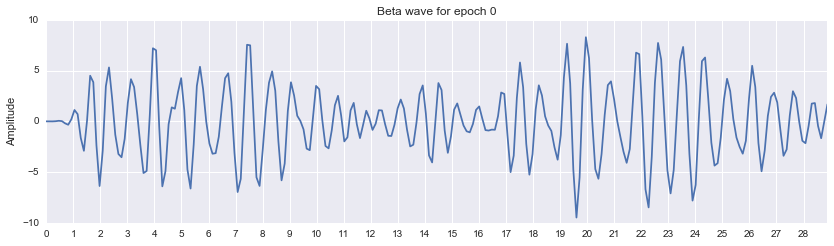

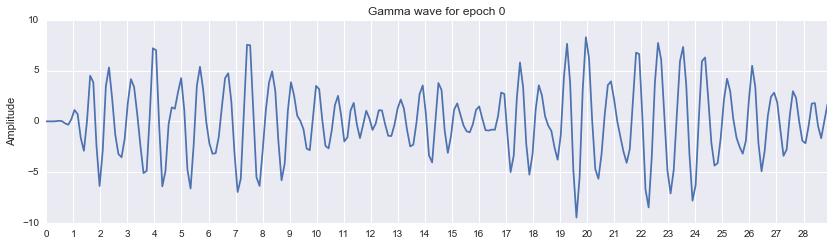

In [115]:
sig = eeg_1.iloc[0, 0:250]
fs=125
delta = butter_bandpass_filter(sig, 0.01, 4, fs, order=10)
theta = butter_bandpass_filter(sig, 4, 8, fs, order=10)
alpha = butter_bandpass_filter(sig, 8, 16, fs, order=10)
beta = butter_bandpass_filter(sig, 16, 32, fs, order=10)
#gamma = butter_bandpass_filter(sig, 16, 32, fs, order=10)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
#ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
#ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(sig)
#ax1.plot(y, label='Filtered signal' )
plt.show()

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Delta wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(delta)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Theta wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(theta)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Alpha wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(alpha)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Beta wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(beta)
plt.show()

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Gamma wave for epoch ' +str(i))
ax1.set_ylabel('Amplitude')
ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
ax1.xaxis.set_ticklabels(range(0,30))
#ax1.set_ylim((low, up))
ax1.plot(gamma)

plt.show()

In [31]:
for i in [22, 29, 34, 250] :   
    sig = eeg_1.iloc[i]
    fs=125
    delta = butter_bandpass_filter(sig, 0.01, 4, fs, order=10)
    theta = butter_bandpass_filter(sig, 4, 8, fs, order=10)
    alpha = butter_bandpass_filter(sig, 8, 16, fs, order=10)
    beta = butter_bandpass_filter(sig, 16, 32, fs, order=10)
    gamma = butter_bandpass_filter(sig, 32, 100, fs, order=10)

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    #ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    #ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(sig)
    #ax1.plot(y, label='Filtered signal' )
    plt.show()

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Delta wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(delta)
    plt.show()

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Theta wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(theta)
    plt.show()

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Alpha wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(alpha)
    plt.show()

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Beta wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(beta)
    plt.show()

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Gamma wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    #ax1.set_ylim((low, up))
    ax1.plot(gamma)

    plt.show()

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

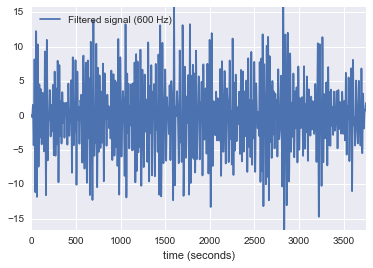

In [98]:
plt.plot(y, label='Filtered signal (%g Hz)' % f0)
plt.xlabel('time (seconds)')
#plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()

# Pulse frequencies

#Pulse frequencies / Discard for other methods

The bands are typically 
- high frequency (HF) from 0.15 to 0.4 Hz, 
- low frequency (LF) from 0.04 to 0.15 Hz, and 
- the very low frequency (VLF) from 0.0033 to 0.04 Hz. 

We will consider only HF and LF 

In [ ]:
po_ir = pd.DataFrame(h5['po_ir'][:])
po_r = pd.DataFrame(h5['po_r'][:])

In [142]:
samples = po_ir[0]
sample_rate= 50
timeIntervalSec=2

In [143]:
freqs, times, spec = signal.spectrogram(samples,
                                fs=sample_rate,
                                window='hann',
                                nperseg=sample_rate*timeIntervalSec,
                                noverlap=0,
                                detrend=False)

In [144]:
pd.DataFrame(spec).head()

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
0,5494.727539,28.176846,33.320900,98.307411,541.879150,1.661563,2240.121094,14.529490,803.267090,1195.713989,...,0.327599,869914.625,2515.596924,1.700316,7437.636230,21.113836,26.525814,12.676035,61659.542969,37.964989
1,13113.916992,98.548630,309.848602,22.547977,579.894714,975.816650,3331.266113,59.183434,1616.918945,1999.067505,...,0.981888,1740826.750,1840.095703,351.872925,39894.136719,54.742313,1.616640,11.867794,121503.500000,67.897415
2,9695.409180,41.418907,1589.212769,62.879940,230.020462,885.483276,324.709076,50.783474,1836.833252,1038.264771,...,1.238778,1733683.125,1476.496460,1750.376831,20729.808594,50.206993,38.693359,0.069435,122622.546875,47.063026
3,12742.422852,665.172729,1420.315308,12.986671,793.913635,527.570312,74.178421,28.832561,1612.098145,1500.627808,...,0.373304,1714747.125,2472.332031,2275.602051,26932.765625,158.232788,38.591942,0.774243,123712.984375,17.730497
4,11682.921875,1334.039307,137.750229,293.510590,47.732506,1082.328979,375.029877,166.122589,1966.905518,1025.601685,...,1.457837,1691246.625,1122.996338,1778.440796,27463.671875,189.335541,18.191473,8.105958,126151.539062,112.809387


In [145]:
spec = np.log(spec.T.astype(np.float32) + 0.00001)

Text(0.5,0,'Seconds')

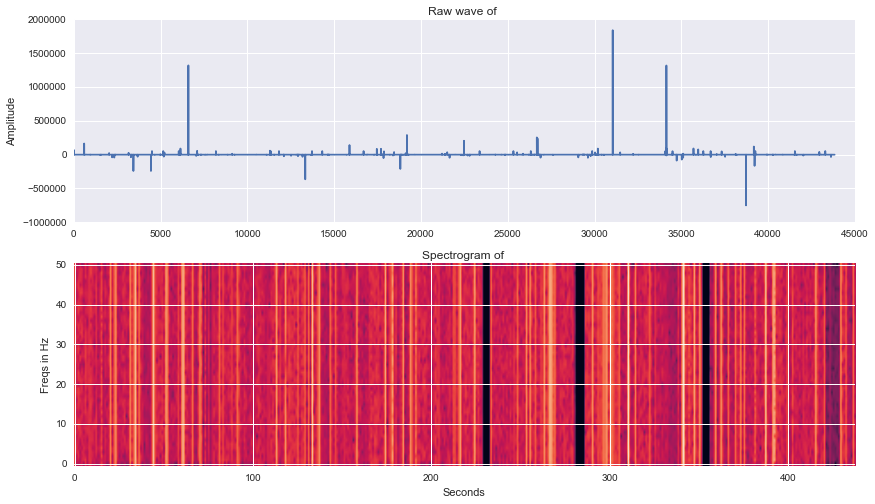

In [151]:
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' )
ax1.set_ylabel('Amplitude')
ax1.plot(samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spec.T, aspect='auto', origin='lower')

ax2.set_title('Spectrogram of ' )
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('')

In [152]:
def spectrogram_by_pulse_bandwidth(sig, sample_rate=50, timeIntervalSec=2):
    VLF = FloatInterval.from_string('[0.0033, 0.04)')
    LF = FloatInterval.from_string('[0.04, 0.15)')
    HF = FloatInterval.from_string('[0.15, 0.4]')
    above04Hz = FloatInterval.from_string('(0.4,)')
    #
    nperseg = int(sample_rate * timeIntervalSec)
    noverlap = 0
    freqs, times, spec = signal.spectrogram(sig,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=sample_rate*timeIntervalSec,
                                    noverlap=noverlap,
                                    detrend=False)
    #Edelta, Etheta, Ealpha, Ebeta, Egamma, Eabove100Hz = np.zeros(6)
    result = pd.DataFrame(np.zeros(spec.shape[1]*4).reshape((4, spec.shape[1])), index=['VLF', 'LF', 'HF', 'Above04Hz'])
    #
    for i in range(0, spec.shape[0]):
        for j in range(0, spec.shape[1]):
            if freqs[i] in VLF:
                result.loc["VLF", j]= result.loc["VLF", j] + spec[i, j]
            elif freqs[i] in LF:
                result.loc["LF", j]= result.loc["LF", j] + spec[i, j]
            elif freqs[i] in HF:
                result.loc["HF", j]= result.loc["HF", j] + spec[i, j]
            elif freqs[i] in above04Hz:
                result.loc["Above04Hz", j]= result.loc["Above04Hz", j] + spec[i, j]    
            else:
                print("error at cell " + str((i, j)))
    return result

In [153]:
sig = po_ir[0]
spectrogram_by_pulse_bandwidth(sig)

error at cell (0, 0)
error at cell (0, 1)
error at cell (0, 2)
error at cell (0, 3)
error at cell (0, 4)
error at cell (0, 5)
error at cell (0, 6)
error at cell (0, 7)
error at cell (0, 8)
error at cell (0, 9)
error at cell (0, 10)
error at cell (0, 11)
error at cell (0, 12)
error at cell (0, 13)
error at cell (0, 14)
error at cell (0, 15)
error at cell (0, 16)
error at cell (0, 17)
error at cell (0, 18)
error at cell (0, 19)
error at cell (0, 20)
error at cell (0, 21)
error at cell (0, 22)
error at cell (0, 23)
error at cell (0, 24)
error at cell (0, 25)
error at cell (0, 26)
error at cell (0, 27)
error at cell (0, 28)
error at cell (0, 29)
error at cell (0, 30)
error at cell (0, 31)
error at cell (0, 32)
error at cell (0, 33)
error at cell (0, 34)
error at cell (0, 35)
error at cell (0, 36)
error at cell (0, 37)
error at cell (0, 38)
error at cell (0, 39)
error at cell (0, 40)
error at cell (0, 41)
error at cell (0, 42)
error at cell (0, 43)
error at cell (0, 44)
error at cell (0, 45

,0,1,2,3,4,5,6,7,8,9,...,428,429,430,431,432,433,434,435,436,437
VLF,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000,0.000000
LF,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000,0.000000
HF,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000,0.000000
Above04Hz,578197.291992,13707.062155,74429.084023,42559.68157,42867.653338,11391.769311,67958.051899,18660.631568,69587.181824,92628.201359,...,23.751868,85104396.25,114397.475025,36666.46276,1.426541e+06,2143.367908,1320.207739,503.411552,6177054.125,3284.379573


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


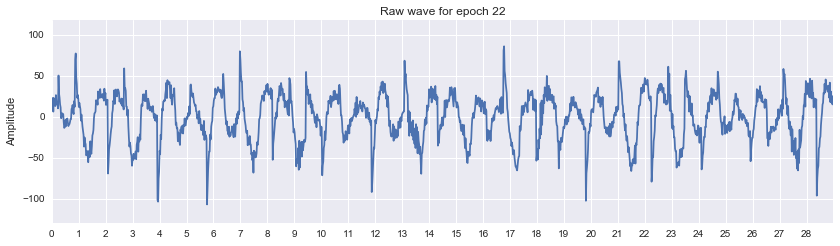

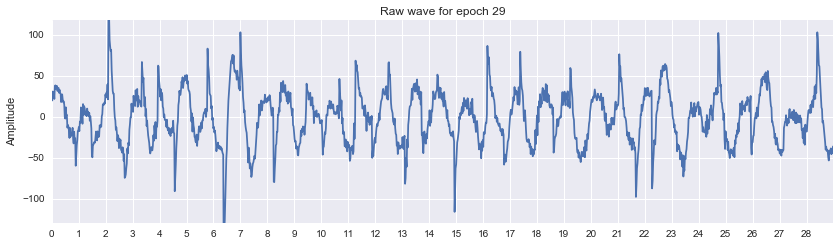

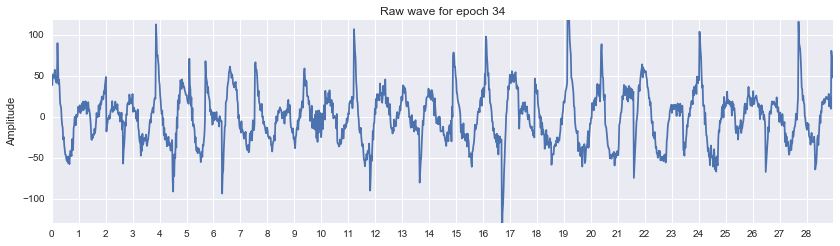

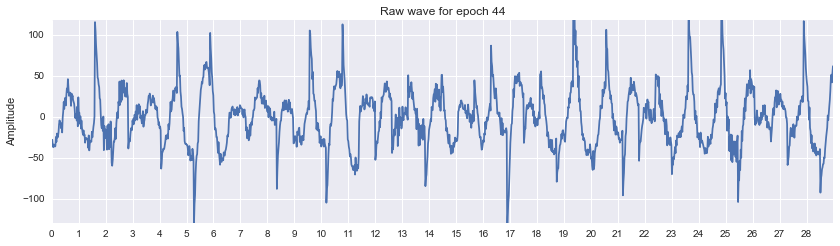

In [117]:
up, low = 0, 0
for i in [22, 29, 34, 44]:
    up = max(eeg_1.iloc[i].max(), up)
    low = min(eeg_1.iloc[i].min(), low)

for i in [22, 29, 34, 44]: #phases : 0, 1, 2, 3, 4

    sig = po_ir.iloc[i]
#    spec = np.log(spectrogram_by_eeg_bandwidth(sig).iloc[:-1, :])

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave for epoch ' +str(i))
    ax1.set_ylabel('Amplitude')
    ax1.xaxis.set_ticks(np.linspace(0, len(sig), num=30))
    ax1.xaxis.set_ticklabels(range(0,30))
    ax1.set_ylim((low, up))
    ax1.plot(sig)
    #ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)


    fig.show()
    
    

Spectrogram Pulse (take 2)
- lowpass filter with a cutoff frequency of 2.5Hz

In [5]:
sample_rate=50
timeIntervalSec=30
nperseg = int(sample_rate * timeIntervalSec)
noverlap = 0
sig = po_ir#[0]

In [6]:
freqs, times, spec = signal.spectrogram(sig,
                                fs=sample_rate,
                                window='hann',
                                nperseg=sample_rate*timeIntervalSec,
                                noverlap=noverlap,
                                detrend=False)

In [46]:
print(freqs.shape, times.shape, spec.shape, spec[0, :76,0].shape)

(751,) (1,) (43830, 751, 1) (76,)


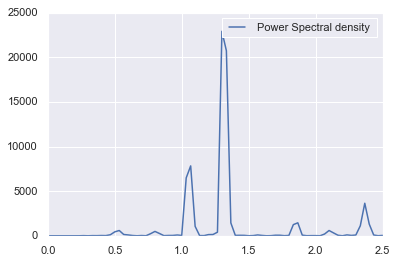

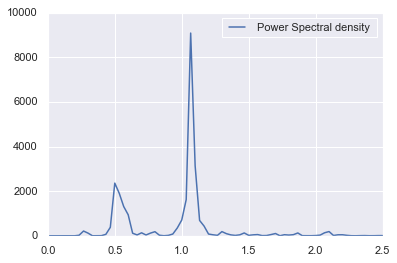

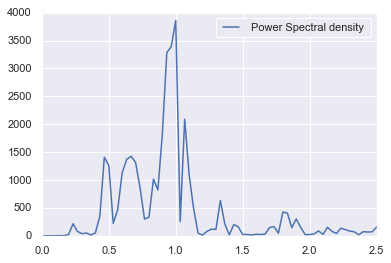

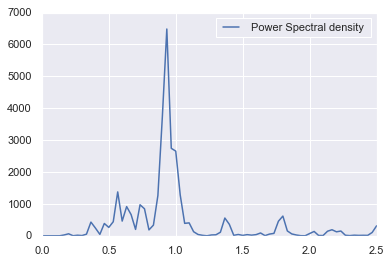

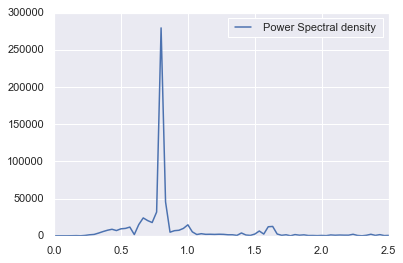

In [55]:
for i in range(5):
    tmp = sig[Y==i]
    plt.plot(freqs[:76], spec[tmp.index[0], :76,0], label = "Power Spectral density ")
    plt.legend(loc='upper right')
    plt.show()


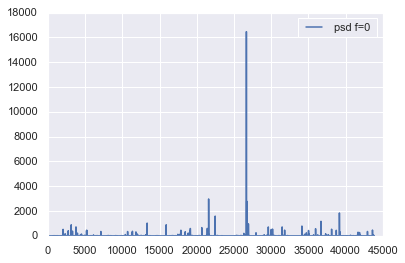

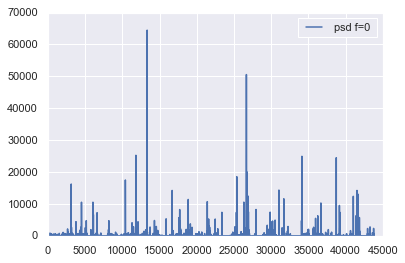

In [59]:
plt.plot(spec[:,0,0], label = "psd f=0 ")
plt.legend(loc='upper right')
plt.show()

plt.plot(spec[:,1,0], label = "psd f=? ")
plt.legend(loc='upper right')
plt.show()

In [40]:
len(freqs[freqs<= 2.5])

76

In [60]:
freqs[freqs<= 2.5]

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333, 2.36666667, 2.4       , 2.43333333, 2.46666

In [44]:
rs = pd.DataFrame(data= spec)


ValueError: Must pass 2-d input

In [ ]:
tmp = pd.DataFrame(data= spec[:, :76,0], columns = np.round(freqs[:76], 3))

In [27]:
int1= FloatInterval.from_string('(0.5, 1]')

In [67]:
#VLF = FloatInterval.from_string('[0.0033, 0.04)')
#LF = FloatInterval.from_string('[0.04, 0.15)')
#HF = FloatInterval.from_string('[0.15, 0.4]')
#above04Hz = FloatInterval.from_string('(0.4,)')
sf = pd.Series(freqs)
VLF=sf[sf<= 0.04].index
LF=sf[sf <=0.15][sf>0.04].index
HF=sf[sf <=0.4][sf>0.15].index
Above04=sf[sf <=2.5][sf>0.4].index
Above04
HF

Int64Index([5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

In [70]:
tmp = pd.DataFrame(data= spec[:, :76,0]) #, columns = np.round(freqs[:76], 3))
df =pd.DataFrame()
df["VLF"] =tmp[VLF].sum(axis=1)
df["LF"] =tmp[LF].sum(axis=1)
df["HF"] =tmp[HF].sum(axis=1)
df["Above04"] =tmp[Above04].sum(axis=1)

df.head()
df.index

RangeIndex(start=0, stop=43830, step=1)

In [71]:
df["Y"]=trainOutput["label"]

In [73]:
for i in range(5):
    print(df[df.Y==i].mean())

VLF        1.305141e+02
LF         5.472849e+04
HF         6.192154e+07
Above04    1.802058e+09
Y          0.000000e+00
dtype: float64
VLF        5.986711e+00
LF         4.215088e+03
HF         3.349988e+06
Above04    6.079689e+07
Y          1.000000e+00
dtype: float64
VLF        2.003351e+01
LF         9.371905e+03
HF         7.772466e+06
Above04    2.251451e+08
Y          2.000000e+00
dtype: float64
VLF        1.340836e+01
LF         6.271692e+03
HF         8.473300e+06
Above04    2.341174e+08
Y          3.000000e+00
dtype: float64
VLF        1.206844e+01
LF         7.008024e+03
HF         7.986149e+06
Above04    2.758492e+08
Y          4.000000e+00
dtype: float64


In [59]:
#df = pd.DataFrame(data= spec[:, :76,0], columns = np.round(freqs[:76], 3))
#df["Y"] = trainOutput["label"]

In [74]:
train = df.iloc[0:int(df.shape[0]*0.8), :]
test = df.iloc[int(df.shape[0]*0.8):, :]

In [76]:
%%time
X = train.iloc[:,:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,:-1]
y_true = test.iloc[:,-1]    
    
xbc = xgb.XGBClassifier(n_estimators = 100, random_state=42, learning_rate= 0.1, max_depth= 8,  subsample= 0.7, 
                        n_jobs=-2)
xbc.fit(X, y)
ll = log_loss(y_true, xbc.predict_proba(X_test))

y_pred = xbc.predict(X_test)
k=cohen_kappa_score(y_true, y_pred)
a= accuracy_score(y_true, y_pred)
#print("for reg_lambda= ", i)
print("log loss = ", ll)
print("kappa = ", k)
print("accuracy = ", a)

log loss =  1.5689974715387116
kappa =  0.026211342648805647
accuracy =  0.31873146246862877
Wall time: 5.78 s


In [62]:
def spectrogram_by_pulse_bandwidth(sig, sample_rate=50, timeIntervalSec=30):
    #focus on all epoch spectrogram
    VLF = FloatInterval.from_string('[0.0033, 0.04)')
    LF = FloatInterval.from_string('[0.04, 0.15)')
    HF = FloatInterval.from_string('[0.15, 0.4]')
    above04Hz = FloatInterval.from_string('(0.4,)')
    #
    nperseg = int(sample_rate * timeIntervalSec)
    noverlap = 0
    freqs, times, spec = signal.spectrogram(sig,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=sample_rate*timeIntervalSec,
                                    noverlap=noverlap,
                                    detrend=False)
    #Edelta, Etheta, Ealpha, Ebeta, Egamma, Eabove100Hz = np.zeros(6)
    result = pd.DataFrame(np.zeros(spec.shape[1]*4).reshape((4, spec.shape[1])), index=['VLF', 'LF', 'HF', 'Above04Hz'])
    #
    for i in range(0, spec.shape[0]):
        for j in range(0, spec.shape[1]):
            if freqs[i] in VLF:
                result.loc["VLF", j]= result.loc["VLF", j] + spec[i, j]
            elif freqs[i] in LF:
                result.loc["LF", j]= result.loc["LF", j] + spec[i, j]
            elif freqs[i] in HF:
                result.loc["HF", j]= result.loc["HF", j] + spec[i, j]
            elif freqs[i] in above04Hz:
                result.loc["Above04Hz", j]= result.loc["Above04Hz", j] + spec[i, j]    
            else:
                print("error at cell " + str((i, j)))
    return result